In [19]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import image
from scipy.ndimage import gaussian_filter

**1.	Selecciona una imagen, cárgala en escala de grises dentro del notebook y asígnala a una variable en Python utilizando openCV. Asegúrate que sean de extensión .jpg, .jpeg o .png.**

In [20]:
imagen1 = cv.imread('Gojo.jpeg')

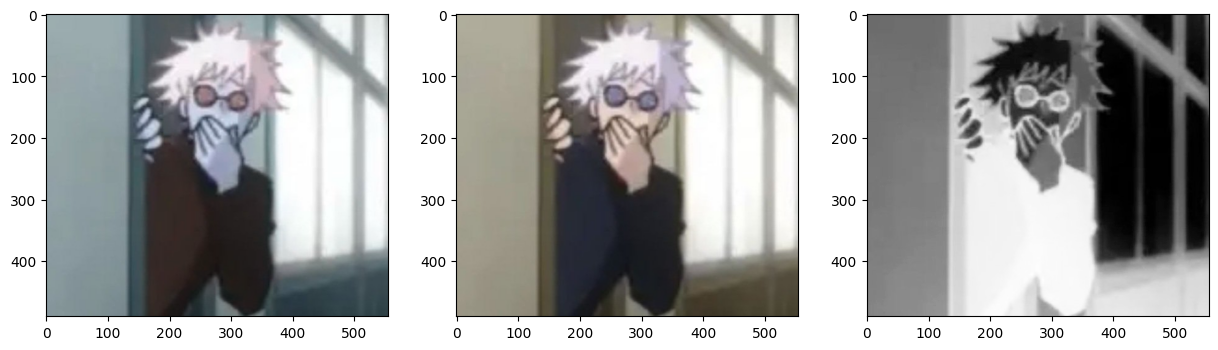

In [21]:
# Converting from BGR to RG
img1_cv2_rgb= cv.cvtColor(imagen1,cv.COLOR_BGR2RGB)
# Converting from RGB a gris
img1_cv2_gray= cv.cvtColor(img1_cv2_rgb,cv.COLOR_RGB2GRAY)
fig, axs= plt.subplots(1,3,figsize=(15, 5))
axs[0].imshow(imagen1, cmap='Greys')
axs[1].imshow(img1_cv2_rgb, cmap='Greys')
axs[2].imshow(img1_cv2_gray, cmap='Greys')
plt.show()

**2.	Extrae y muestra los puntos de interés SIFT de la imagen del paso anterior, indicando su orientación y escala.**




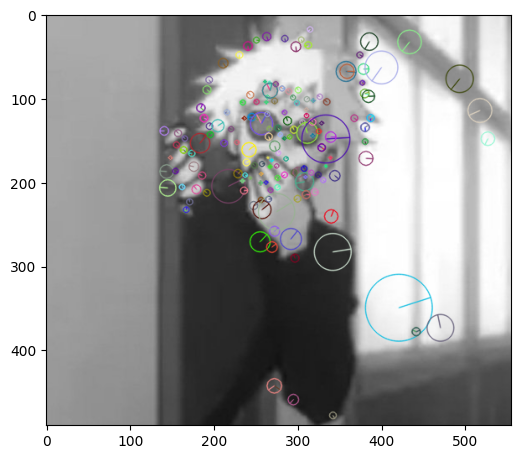

In [22]:
sift = cv.xfeatures2d.SIFT_create()
kp1, descriptor1 = sift.detectAndCompute(imagen1, None)
img1kp = cv.drawKeypoints(img1_cv2_gray, kp1, imagen1,
                          flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(6, 6))
plt.imshow(img1kp)

**3.	Gira la imagen 60° con la función cv2.warpAffine, extrae y muestra los puntos de interés SIFT.**

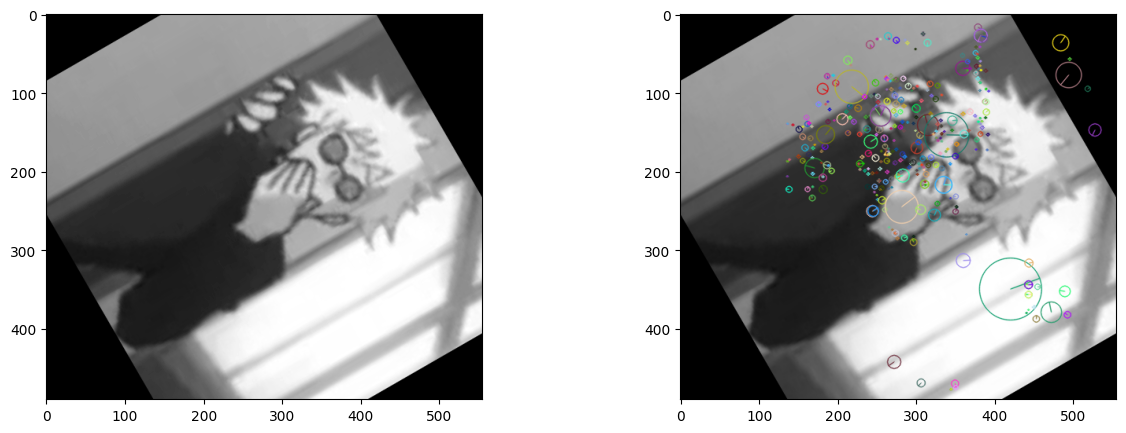

In [23]:
centro = (img1_cv2_gray.shape[1]//2,img1_cv2_gray.shape[0]//2)
matriz_rot = cv.getRotationMatrix2D(centro,-60,1)
img2_rot = cv.warpAffine(img1_cv2_gray, matriz_rot,(img1_cv2_gray.shape[1],img1_cv2_gray.shape[0]))


sift = cv.xfeatures2d.SIFT_create()
kp1, descriptor1 = sift.detectAndCompute(imagen1, None)
img1kp = cv.drawKeypoints(img2_rot, kp1, imagen1,
                          flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs= plt.subplots(1,2,figsize=(15, 5))
axs[0].imshow(img2_rot, cmap='gray')
axs[1].imshow(img1kp, cmap='Greys')
plt.show()

**4.	Mapea los puntos de interés de las imágenes utilizadas en los pasos 1 y 3. Descarta las coincidencias incorrectas utilizando la prueba de proporción propuesta en el siguiente recurso y muestra las coincidencias entra ambas imágenes con líneas.**

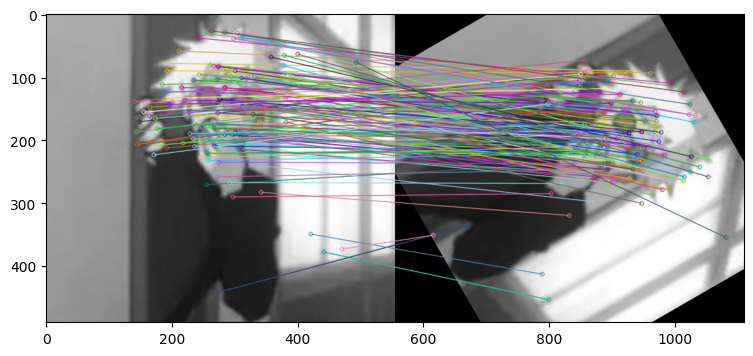

In [24]:
# Se implementan las funciones de "SIFT" para mapear los puntos de interes entre ambas imagenes, descartando las coincidencias incorrectas con la prueba de proporción y sus coincidencias.
sift = cv.xfeatures2d.SIFT_create()

kp1, descriptor1 = sift.detectAndCompute(img1_cv2_gray, None)
kp2, descriptor2 = sift.detectAndCompute(img2_rot, None)

# Las coincidencias de caracteristicas utilizando BFMatcher que es un descriptor de una característica en el primer set y se empareja con todas las otras características en el segundo set
# usando un cálculo de distancia, con lambda se calculan las distancias y se realiza el mapeo entre ambas imagenes acomodandose con respecto a su posición y escala de tamaño.
bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)

match1 = bf.match(descriptor1,descriptor2)
match1 = sorted(match1, key = lambda x: x.distance)

img_mapeo = cv.drawMatches(img1_cv2_gray, kp1, img2_rot, kp2, match1[:200], img2_rot, flags = 2)
plt.figure(figsize=(9,9))
plt.imshow(img_mapeo)

**5.	Utiliza el algoritmo RANSAC para encontrar la transformación afín de la imagen girada hacia la imagen original.**

In [25]:
def estima_afin(s,t):
  num = s.shape[1]
  M =np.zeros((2 * num, 6))
  for i in range (num):
    temp = [[s[0,i],s[1,i],0,0,1,0],
            [0, 0, s[0,i], s[1,i],0,1]]
    M[2 * i: 2 * i + 2, :] = np.array(temp)

  b = t.T.reshape((2 * num, 1))
  theta = np.linalg.lstsq(M,b)[0]

  X = theta[:4].reshape((2,2))
  Y = theta[4:]
  return X,Y

In [26]:
K = 2
threshold = 2
ITER_NUM = 2000


def residual_lengths(X, Y, s, t):
  e = np.dot(X,s) + Y
  diff_square = np.power(e - t,2)
  residual = np.sqrt(np.sum(diff_square, axis = 0))
  return residual


def ransac_fit(pts_s, pts_t):
  inliers_num = 0
  A = None
  t = None
  inliers = None

  for i in range(ITER_NUM):
    idx = np.random.randint(0, pts_s.shape[1],(K, 1))
    A_tmp, t_tmp = estima_afin(pts_s[:,idx], pts_t[:, idx])
    residual = residual_lengths(A_tmp, t_tmp, pts_s, pts_t)
    if not(residual is None):
      inliers_tmp = np.where(residual < threshold)
      inliers_num_tmp = len(inliers_tmp[0])
      if inliers_num_tmp > inliers_num:
        inliers_num = inliers_num_tmp
        inliers = inliers_tmp
        A = A_tmp
        t = t_tmp
      else:
        pass
  return A, t, inliers

In [27]:
def extract_SIFT(img):
  kp, desc = sift.detectAndCompute(img1_cv2_gray, None)
  kp, desc =sift.detectAndCompute(img1_cv2_gray, None)
  kp = np.array([p.pt for p in kp]).T
  return kp, desc

def match_SIFT(descriptor_source, descriptor_target):
  bf =cv.BFMatcher()
  matches = bf.knnMatch(descriptor_source, descriptor_target, k=2)
  pos = np.array([],dtype=np.int32).reshape((0,2))
  matches_num = len(matches)
  for i in range(matches_num):
    if matches[i][0].distance <= 0.5 * matches[i][1].distance:
      temp = np.array([matches[i][0].queryIdx,
                      matches[i][0].trainIdx])
      pos = np.vstack((pos, temp))
  return pos


def affine_matrix(s,t,pos):
    s = s[:, pos[:,0]]
    t = t[:, pos[:,1]]
    _,_, inliers = ransac_fit(s,t)
    s = s[:,inliers[0]]
    t = t[:,inliers[0]]

    A, t = estima_afin(s,t)
    M = np.hstack((A, t))
    return M

In [28]:
img_source = img1_cv2_gray
img_target = img2_rot

In [29]:
keypoint_source, descriptor_source = extract_SIFT(img1_cv2_gray)
keypoint_target, descriptor_target = extract_SIFT(img2_rot)
pos = match_SIFT(descriptor_source, descriptor_target)
H = affine_matrix(keypoint_source, keypoint_target, pos)

<ipython-input-25-fc437e5d6c67>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  M[2 * i: 2 * i + 2, :] = np.array(temp)
<ipython-input-25-fc437e5d6c67>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(M,b)[0]


In [30]:
rows, cols, = img2_rot.shape
warp = cv.warpAffine(img_source, H, (cols,rows))
merge = np.uint8(img2_rot * 0.5 + warp *0.5)

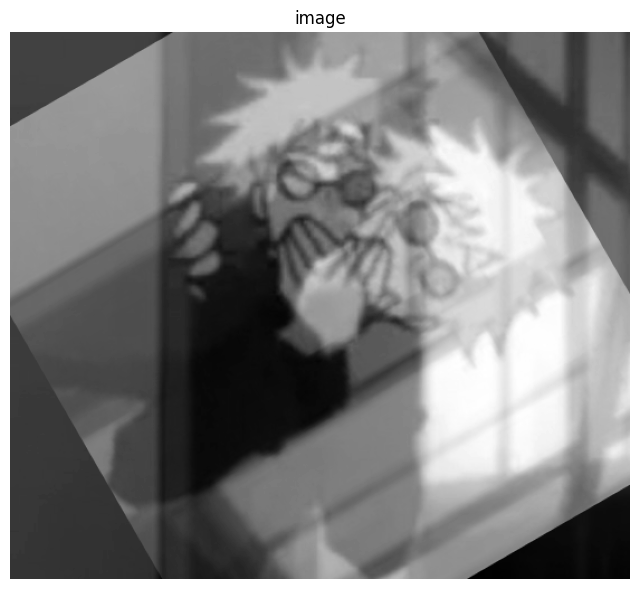

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(merge,cmap="gray")
ax.axis("off")
ax.set_title("image")
plt.show()